
to do list:

* Find a way to test more hyperparameters faster and search about "BayeSearch".

* Search whether the t-test is appropriate to do the hypothesis test in the 2 result sets from the best neural network models.



# **All dependencies that are necessary**

In [ ]:
!pip install arff
!pip install tensorflow
!pip install --upgrade scipy

In [53]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn import preprocessing
from os import listdir
from os.path import isfile, join
from datetime import datetime,date
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras import initializers
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import r_regression
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_ind
import scipy.stats
import seaborn as sns
import math
import json

# **Opening the data set**

The data set is loaded from a CSV file named "meteorological_data" that I created and cleaned in my other python file. Check out "generateData" to obtain more information about.

In [3]:
dataFrame=pd.read_csv('meteorological_data.csv')

dataFrame['mes'] = [mes[5:7] for mes in dataFrame['data completa'] ]
dataFrame['ano'] = [ano[0:4] for ano in dataFrame['data completa'] ]
id_2 = ['A305','A306','A314','A315','A319','A324','A325','A332','A339','A342','A347','A358','A359','A360','A368','A369']
localization = ['FORTALEZA','SOBRAL','GUARAMIRANGA','BARBALHA','IGUATU','TAUA','QUIXERAMOBIM','MORADA NOVA','JAGUARUANA','CRATEUS','CAMPOS SALES','JAGUARIBE','ITAPIPOCA','ACARAU','TIANGUA','QUIXADA']


display(dataFrame)

,TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C),UMIDADE REL. MAX. NA HORA ANT. (AUT)(%),TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C),UMIDADE REL. MIN. NA HORA ANT. (AUT)(%),RADIACAO GLOBAL(Kj/m²),"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)","UMIDADE RELATIVA DO AR, HORARIA(%)","VENTO, VELOCIDADE HORARIA(m/s)",latitude,longitude,altura,estacao_id,dia do ano,data completa,temperatura media,Eo_samani,Eo_FAO,mes,ano
0,29.6,84.0,26.7,68.0,2478.500000,1008.690909,77.636364,2.381818,-0.066599,-0.672610,29.55,0.0,49,2003-02-18,28.15,2.815185,2.158130,02,2003
1,31.5,95.0,24.3,62.0,1320.500000,1008.700000,80.750000,2.329167,-0.066599,-0.672610,29.55,0.0,50,2003-02-19,27.90,4.412632,4.312026,02,2003
2,27.6,95.0,24.1,78.0,2386.444444,1008.354167,88.333333,1.279167,-0.066599,-0.672610,29.55,0.0,51,2003-02-20,25.85,2.939072,3.032922,02,2003
3,30.8,96.0,22.0,61.0,1246.666667,1008.354167,83.083333,1.708333,-0.066599,-0.672610,29.55,0.0,52,2003-02-21,26.40,4.719712,4.768149,02,2003
4,31.2,94.0,24.2,59.0,1431.000000,1008.283333,82.041667,1.858333,-0.066599,-0.672610,29.55,0.0,53,2003-02-22,27.70,4.333662,4.317706,02,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65718,36.8,42.0,31.7,31.0,3055.208250,988.400000,33.500000,3.075000,-0.086896,-0.681677,193.00,15.0,339,2019-12-05,34.25,4.155351,3.864984,12,2019
65719,37.6,33.0,34.7,28.0,2419.698000,985.700000,29.000000,2.200000,-0.086896,-0.681677,193.00,15.0,341,2019-12-07,36.15,3.246348,2.578275,12,2019
65720,34.9,67.0,29.4,40.0,1530.386800,988.720000,51.200000,2.600000,-0.086896,-0.681677,193.00,15.0,342,2019-12-08,32.15,4.138430,3.941287,12,2019
65721,35.1,76.0,26.6,36.0,2624.976200,989.040000,45.400000,3.860000,-0.086896,-0.681677,193.00,15.0,343,2019-12-09,30.85,5.009957,4.618717,12,2019


# **Setting parameters and selecting features**

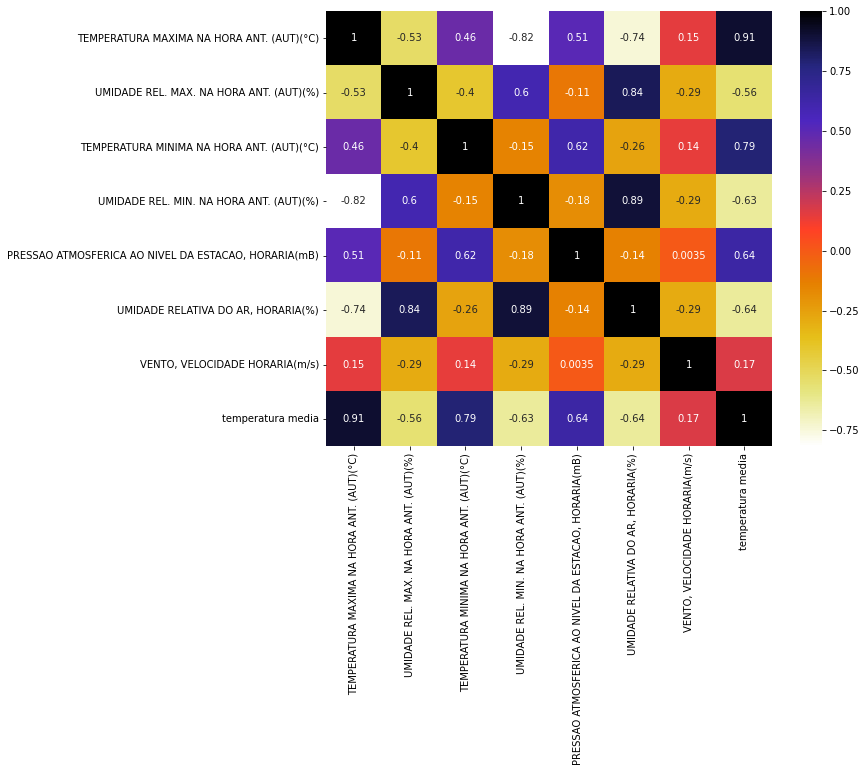

In [4]:
plt.figure(figsize=(10,8))
correlation = dataFrame.drop(columns=['Eo_samani','latitude','longitude','altura','estacao_id','RADIACAO GLOBAL(Kj/m²)','dia do ano','Eo_FAO']).corr()
sns.heatmap(correlation,annot =True,cmap = plt.cm.CMRmap_r)
plt.show()

In [5]:
features_correlation = dict()

for i in range(len(correlation)):
  
  features_correlation[correlation.columns[i]] = []

  for j in range(len(correlation)):
    if correlation.iloc[i,j]>0.6 and i is not j:
      features_correlation[correlation.columns[i]].append(correlation.columns[j])


display(features_correlation)

{'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)': ['TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C)',
  'temperatura media'],
 'TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C)': ['temperatura media'],
 'TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C)': ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)',
  'temperatura media'],
 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)': ['UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)',
  'UMIDADE RELATIVA DO AR, HORARIA(%)'],
 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)': ['UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)',
  'UMIDADE RELATIVA DO AR, HORARIA(%)'],
 'UMIDADE RELATIVA DO AR, HORARIA(%)': ['UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)',
  'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)'],
 'VENTO, VELOCIDADE HORARIA(m/s)': [],
 'temperatura media': ['TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C)',
  'TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C)',
  'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)']}

In [6]:
param_grid = {
    'learning_rate':[0.001, 0.01],
    'layer_number':[2,3,4],
    'neuron_number':[3,4,5,6],
    'features_delete':[
    #                   ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)','RADIACAO GLOBAL(Kj/m²)','VENTO, VELOCIDADE HORARIA(m/s)'],
                       ['UMIDADE RELATIVA DO AR, HORARIA(%)','UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)','UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)','RADIACAO GLOBAL(Kj/m²)','VENTO, VELOCIDADE HORARIA(m/s)'],
                       ['RADIACAO GLOBAL(Kj/m²)','temperatura media','UMIDADE RELATIVA DO AR, HORARIA(%)','UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)','TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C)']
                       ],
    'epochs':[20,30,40,50],
    #'data_date':['2010-02-11','2013-02-11','2015-02-11']
    'data_date':['2010-02-11']
    }
parameters=list(ParameterGrid(param_grid))
display(len(parameters))

192

# **Class and methods used**

This section contains all methods and classes necessary to perform the evapotranspiration predictions by neural network and evaluation of their results. Most functions and methods names are self-explanatory.

##**Classes**



*   Neural_test
  this class is responsible to do all steps necessary to perform the prediction with a certain set of hyperparameters. I provide a short explanation of the main methods.


1.   splitting_data():
It splits the data set into training, validation and test. The Validation set corresponds to 20 percent of the training set. The useless columns are dropped from the data sets.

2.   standardize_data():
Standardize the training and test sets in order to prevent the magnitude of the data does not affect the prediction. the standardization is based on the following equation:

\begin{align}
\frac{(x_i - \mu)}{\sigma}
\end{align}

$x_i$ consists of a data from a data set and $\mu$ and $\sigma$ the mean and standard deviation of this data set.

3.   Model() and Fit(): These functions set up the neural network model with a combination of the hyperparameters. Check out above what hyperparameters I had selected.


In [7]:
class Neural_test:

  def __init__(self,dataframe,drop_columns):

    self.data=dataFrame.drop(labels=drop_columns,axis=1)
  
  def splitting_data(self,date,name_empirical_model):

    empirical_model=[]
    self.data['data completa'] = pd.to_datetime(self.data['data completa'])
    self.data = self.data.set_index(self.data['data completa'])
    self.data = self.data.sort_index()
    
    self.train_dataset = self.data[date[0]:date[1]]
    self.test_dataset  = self.data[date[2]:]
   
    self.test_date=self.test_dataset.index

    self.train_labels = self.train_dataset.loc[:,'Eo_FAO']
    self.test_labels = self.test_dataset.loc[:,'Eo_FAO']

    self.empirical_model=self.test_dataset.loc[:,name_empirical_model]

    self.train_dataset=self.train_dataset.drop(labels=name_empirical_model,axis=1)
    self.test_dataset=self.test_dataset.drop(labels=name_empirical_model,axis=1)

    self.mes = self.test_dataset['mes']
    self.estacao_id = self.test_dataset['estacao_id']
    self.ano = self.test_dataset['ano']

    self.train_dataset=self.train_dataset.drop(labels=['data completa','Eo_FAO','estacao_id','mes','ano'],axis=1)
    self.test_dataset=self.test_dataset.drop(labels=['data completa','Eo_FAO','estacao_id','mes','ano'],axis=1)


  def standardize_data(self):

    scaler = StandardScaler()

    scaler.fit(self.train_dataset)
    self.normed_train_data=pd.DataFrame(scaler.transform(self.train_dataset))
    scaler.fit(self.test_dataset)
    self.normed_test_data=pd.DataFrame(scaler.transform(self.test_dataset))

  def get_train(self):
    return self.train_dataset

  def Model(self,Loss,Metrics,activation_function,Learning_rate,layer_number,neuron_number):

    initializer = tf.keras.initializers.HeNormal(seed=1)
    model = keras.Sequential()

    for index in range(layer_number-1):
      if index == 0:
        model.add(layers.Dense(neuron_number, activation=activation_function, input_shape=[len(self.normed_train_data.keys())],kernel_initializer=initializer))
      else:
        model.add(layers.Dense(neuron_number, activation=activation_function,kernel_initializer=initializer))
    
    model.add(layers.Dense(1))


    optimizer = tf.keras.optimizers.RMSprop(learning_rate=Learning_rate)
    
    model.compile(loss=Loss,
                optimizer=optimizer,
                metrics=Metrics
                )
    
    self.model=model
    
  def Fit(self,Epochs,Validation_split,Verbose,show_history=True):

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=50)
    
    history = self.model.fit(
    x=self.normed_train_data,
    y=self.train_labels,
    validation_split=Validation_split,
    verbose=Verbose,
    epochs=Epochs
    #callbacks=[es]
    )

    if show_history:
      historico = pd.DataFrame(history.history)
      historico['epoch'] = history.epoch
      display(historico.tail())

    return history
    
  def prediction(self):

    self.prediction_test = self.model.predict(self.normed_test_data).flatten()
    self.prediction_test=pd.Series(self.prediction_test)
  
  def compare(self,limit,show=False):
    
    [test_labels,empirical_model]=[self.test_labels,self.empirical_model]

    if show:
      plt.plot(test_labels[0:limit].reset_index(drop=True),test_labels[0:limit].reset_index(drop=True))      
      plt.plot(test_labels[0:limit].reset_index(drop=True),self.prediction_test[0:limit],'x')
      plt.plot(test_labels[0:limit].reset_index(drop=True),empirical_model[0:limit],'x')
      plt.ylabel('Rede Neural')
      plt.xlabel('Fao 56')
      plt.savefig('grap.png')
      plt.show()

    r2=r2_score(test_labels, self.prediction_test)
    #r2_2=r2_score(test_labels, empirical_model)
    print(r2)
    return r2



class organize():

  def __init__(self,simulation_result):

    self.simulation_result=simulation_result

  def organize_results_two_sets(self,qtd,store_excel=False):

    result_dic=dict()
    result_dic['results_of_simulation00'] = dict()
    result_dic['results_of_simulation01'] = dict()

    condition = [['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'],['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)']]

    for index in range(len(simulation_result['id'])):

      #result_dic['simulation '+str(index)]={'parameters':simulation_result['parameters'][index],'id':simulation_result['id'][index],'history':simulation_result['history'][index],'result':simulation_result['result'][index]}
      for index2 in range(len(condition)):
        if simulation_result['parameters'][index]['features_delete'] == condition[index2]: 
          result_dic['results_of_simulation0'+str(index2)][simulation_result['id'][index]] = dict()
          result_dic['results_of_simulation0'+str(index2)][simulation_result['id'][index]]['result_R2']=simulation_result['result_R2'][index]
          result_dic['results_of_simulation0'+str(index2)][simulation_result['id'][index]]['result_MSE']=simulation_result['result_MSE'][index]
          result_dic['results_of_simulation0'+str(index2)][simulation_result['id'][index]]['parameters']=simulation_result['parameters'][index]
          print(simulation_result['parameters'][index])
    results_of_simulation00 = sorted(result_dic['results_of_simulation00'].items(), key=lambda item: item[1]['result_R2'])
    results_of_simulation01 = sorted(result_dic['results_of_simulation01'].items(), key=lambda item: item[1]['result_R2'])
    
    if store_excel:

      pd.DataFrame(results_of_simulation00).to_excel("results_of_simulation00.xlsx",index=False)
      pd.DataFrame(results_of_simulation01).to_excel("results_of_simulation01.xlsx",index=False)
    
    return [results_of_simulation00,results_of_simulation01]



##**Functions**

In [54]:
def creating_two_boxplot(data_01,data_02,ylabel,title,showfliersC):

  plt.boxplot(data_01,showfliers=showfliersC)
  plt.boxplot(data_02,showfliers=showfliersC,positions=[2])
  plt.xlabel('Boxplot')
  plt.ylabel(ylabel)
  plt.title(title)
  plt.grid()
  plt.show()


def Creating_result_table(results_dict,load_dataset_from_excel):

  matrix = []

  if load_dataset_from_excel:
    for id in range(len(results_dict),0,-1):
      matrix.append([results_dict[id]['parameters']['data_date'],results_dict[id]['parameters']['epochs'],len(results_dict[id]['parameters']['features_delete']),results_dict[id]['parameters']['learning_rate'],results_dict[id]['result_MSE'],results_dict[id]['result_R2'],results_dict[id]['parameters']['layer_number'],results_dict[id]['parameters']['neuron_number'] ])
  else:
    for id in range(len(results_dict)-1,0,-1):
      matrix.append([results_dict[id][1]['parameters']['data_date'],results_dict[id][1]['parameters']['epochs'],len(results_dict[id][1]['parameters']['features_delete']),results_dict[id][1]['parameters']['learning_rate'],results_dict[id][1]['result_MSE'],results_dict[id][1]['result_R2'],results_dict[id][1]['parameters']['layer_number'],results_dict[id][1]['parameters']['neuron_number']])
  
  matrix = pd.DataFrame(matrix).rename(columns={0:'Data de inicio',1:'épocas',2:'features deletadas',3:'taxa de aprendizagem',4:'MSE',5:'coeficiente de determinação',6:'Numero de camadas',7:'numero de neurônios'})
  
  return matrix

def make_prediction(dataFrame,parameter):

  neural_network = Neural_test(dataFrame,parameter['features_delete'])  
  neural_network.splitting_data([parameter['data_date'],'2018-01-01','2018-01-02'],['Eo_samani'])
  neural_network.standardize_data()
  neural_network.Model('mse',['mae', 'mse'],'relu',parameter['learning_rate'],parameter['layer_number'],parameter['neuron_number'])
  history = neural_network.Fit(parameter['epochs'],0.2,0,False)

  neural_network.prediction()
  neural_network.compare(350)
  return  [neural_network,history]



def get_results(parameters):
  
  [index,simulation_result,keys,mse] = [0,dict(),['parameters','result_R2','result_MSE','id','history'],0]

  for key in keys:
    simulation_result[key] = [] 

  for parameter in parameters:

    print('Parameters used:\n Features para serem deletadas: '+str(parameter['features_delete'])+' taxa de aprendizagem: '+str(parameter['learning_rate'])+' Epochs: '+str(parameter['epochs'])+' data: '+parameter['data_date'])
    print('numero de layers: '+str(parameter['layer_number'])+' numero de neuronios: '+str(parameter['neuron_number'])+'\n' )
    neural_network = Neural_test(dataFrame,parameter['features_delete'])
    neural_network.splitting_data([parameter['data_date'],'2018-01-01','2018-01-02'],['Eo_samani'])
    neural_network.standardize_data()
    
    neural_network.Model('mse',['mae', 'mse'],'relu',parameter['learning_rate'],parameter['layer_number'],parameter['neuron_number'])
    
    history = neural_network.Fit(parameter['epochs'],0.2,0,True)
    
    neural_network.prediction()
    
    coeficent=neural_network.compare(250)
    mse=mean_squared_error(neural_network.test_labels,neural_network.prediction_test)
    simulation_result['parameters'].append(parameter) 
    simulation_result['id'].append(index)
    simulation_result['result_R2'].append(coeficent)
    simulation_result['result_MSE'].append(mse)
    simulation_result['history'] = history
    display(mse)
    print(index)
    index+=1

  return simulation_result


def get_results_stored_in_excel_and_convert_to_dict(name_excel):
    
  excel = pd.read_excel(name_excel)

  dataset = dict()
  
  for index in range(len(excel[1])-1,0,-1):
        
    dataset[index] = dict()
    json_data = json.loads(excel[1][index].replace("'",'"'))
    dataset[index]['parameters'] = json_data['parameters']
    dataset[index]['result_R2'] = json_data['result_R2']
    dataset[index]['result_MSE'] = json_data['result_MSE']

  return dataset


def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]


def get_graphs_and_metrics_grouped_by_estacao_id(prediction,test,split,year,localization,id_2,save_picture = False,show_picture = False):

  prediction_labels_gruopby_estacao_id = [x for x in prediction[prediction['ano']==year].groupby('estacao_id')]
  test_labels_gruopby_estacao_id = [x for x in test[test['ano']==year].groupby('estacao_id')]  
  
  station_name_index = [int(estation[1]['estacao_id'][0]) for estation in test_labels_gruopby_estacao_id]
  
  results_simulations_by_estation = dict()

  for index in range(len(station_name_index)):
    
    results_simulations_by_estation[localization[station_name_index[index] ] ] = dict()
    
    results_simulations_by_estation[localization[station_name_index[index] ] ]['código da estação'] = id_2[index]
    results_simulations_by_estation[localization[station_name_index[index] ] ]['Quantidade de dados'] = len(prediction_labels_gruopby_estacao_id[index][1]) 
    
    prediction_labels_gruopby_estacao_id_groupby_month=prediction_labels_gruopby_estacao_id[index][1].groupby([split]).mean().drop(columns={'estacao_id'})
    test_labels_gruopby_estacao_id_groupby_month=test_labels_gruopby_estacao_id[index][1].groupby([split]).mean().drop(columns={'estacao_id'})
    
    results_simulations_by_estation[localization[station_name_index[index] ] ]['coeficiente de determinação(dia)'] = r2_score(test_labels_gruopby_estacao_id[index][1]['Eo_FAO'],prediction_labels_gruopby_estacao_id[index][1][0])
    results_simulations_by_estation[localization[station_name_index[index] ] ]['MSE(dia)'] = mean_squared_error(test_labels_gruopby_estacao_id[index][1]['Eo_FAO'],prediction_labels_gruopby_estacao_id[index][1][0])

    axs = plt.figure(figsize=(13,3),constrained_layout=True).subplots(1, 3)
    axs = trim_axs(axs, 3)
    axs[0].plot(prediction_labels_gruopby_estacao_id[index][1][0].reset_index(drop=True),':', label = 'Rede Neural')
    axs[0].plot(test_labels_gruopby_estacao_id[index][1]['Eo_FAO'].reset_index(drop=True),':', label = 'FAO-56')
    axs[0].legend()
    axs[0].grid()
    axs[0].set_xlabel('dia')
    axs[0].set_ylabel('Eo')
    axs[0].set_title('Eo para a estação de '+str(localization[station_name_index[index]])+'(dia)')

    if save_picture:
      plt.savefig("evapotranspiration graph per day of estation "+str(localization[station_name_index[index]]))

    coeficient_of_determination = r2_score(prediction_labels_gruopby_estacao_id_groupby_month,test_labels_gruopby_estacao_id_groupby_month)

    results_simulations_by_estation[localization[station_name_index[index] ] ]['coeficiente de determinação(mes)'] = coeficient_of_determination
    results_simulations_by_estation[localization[station_name_index[index] ] ]['MSE(mes)'] = mean_squared_error(prediction_labels_gruopby_estacao_id_groupby_month,test_labels_gruopby_estacao_id_groupby_month)

    axs[1].plot(prediction_labels_gruopby_estacao_id_groupby_month, label = 'Rede Neural')
    axs[1].plot(test_labels_gruopby_estacao_id_groupby_month, label = 'FAO-56')
    axs[1].legend()
    axs[1].grid()
    axs[1].set_xlabel(split)
    axs[1].set_ylabel('Eo')
    axs[1].set_title('Eo para a estação de '+str(localization[station_name_index[index]])+'(mes)')

    if save_picture:
      plt.savefig("evapotranspiration graph per month of estation "+str(localization[station_name_index[index]]))

    axs[2].plot(test_labels_gruopby_estacao_id[index][1]['Eo_FAO'].drop(columns={'estacao_id','mes'}),test_labels_gruopby_estacao_id[index][1]['Eo_FAO'].drop(columns={'estacao_id','mes'}),label = 'FAO-56')
    axs[2].plot(test_labels_gruopby_estacao_id[index][1]['Eo_FAO'].drop(columns={'estacao_id','mes'}),prediction_labels_gruopby_estacao_id[index][1][0].drop(columns={'estacao_id','mes'}),'xb',label = 'Rede Neural')
    axs[2].legend()
    axs[2].grid()
    #plt.text(5,5,'r^2 = '+str(round(coeficient_of_determination,2)),ax.transAxes )
    axs[2].set_ylabel('Rede neural')
    axs[2].set_xlabel('FAO-56')
    if show_picture:
      plt.show()
    if save_picture:
      plt.savefig("evapotranspiration graph fdfedfsfsd "+str(id_2[index]))
    
  return pd.DataFrame(results_simulations_by_estation)

def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1
    dfd = y.size-1 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f, p


# **Prediction and Tuning**

In this section, the training results of the neural network models are going to shown and their hyperparameters will be selected based on the highest coefficients of determination. The algorithm makes and stores 90 predictions using all combinations of the above hyperparameters.                           

**Read-me**: The procedure of doing all training and predictions and obtaining the metrics from each hyperparameter takes too much time. To avoid this problem, I already saved the best results in two CSV files named "results_of_simulation00.xlsx" and "results_of_simulation01.xlsx". Set the  "load_dataset_from_excel" variable as True and you are going to be able to access the results as much as the parameters used without redoing the model training. 

In [ ]:
simulation_result = get_results(parameters)

In [9]:
load_dataset_from_excel = True

if load_dataset_from_excel:
  best_results_of_simulation00 = get_results_stored_in_excel_and_convert_to_dict('results_of_simulation00.xlsx')
  best_results_of_simulation01 = get_results_stored_in_excel_and_convert_to_dict('results_of_simulation01.xlsx')

else:

  organizing = organize(simulation_result)
  [best_results_of_simulation00,best_results_of_simulation01] = organizing.organize_results_two_sets(True,10)

result_table00 = Creating_result_table(best_results_of_simulation00,load_dataset_from_excel)
result_table01 = Creating_result_table(best_results_of_simulation01,load_dataset_from_excel)

In [11]:
parameter00 = {
    'learning_rate':result_table00[0:1]['taxa de aprendizagem'][0],
#    'momentum' : [0.0, 0.2, 0.4, 0.6],
    'features_delete':
                       ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)','RADIACAO GLOBAL(Kj/m²)','VENTO, VELOCIDADE HORARIA(m/s)'],
    'epochs':result_table00[0:1]['épocas'][0],
    'data_date':result_table00[0:1]['Data de inicio'][0],
    'layer_number':result_table01[0:1]['Numero de camadas'][0],
    'neuron_number':result_table01[0:1]['numero de neurônios'][0]
    }

display(result_table00[:20].drop(columns=['Data de inicio']))
display(result_table00.groupby(['Numero de camadas','numero de neurônios','épocas','taxa de aprendizagem']).mean().drop(columns={'features deletadas'}).iloc[0:20,:])

,épocas,features deletadas,taxa de aprendizagem,MSE,coeficiente de determinação,Numero de camadas,numero de neurônios
0,30,3,0.010,0.041245,0.953480,4,6
1,30,3,0.010,0.043645,0.950773,4,4
2,30,3,0.001,0.044651,0.949638,4,6
3,30,3,0.010,0.046933,0.947065,3,4
4,50,3,0.001,0.047080,0.946898,4,6
5,50,3,0.001,0.047442,0.946490,4,4
6,40,3,0.010,0.048185,0.945652,4,4
7,30,3,0.001,0.049180,0.944530,3,6
8,50,3,0.001,0.049268,0.944431,3,6
9,40,3,0.001,0.049541,0.944122,3,6


MSE  \
Numero de camadas numero de neurônios épocas taxa de aprendizagem             
2                 3                   20     0.001                 0.206515   
                                             0.010                 0.074312   
                                      30     0.001                 0.070344   
                                             0.010                 0.079346   
                                      40     0.001                 0.127713   
                                             0.010                 0.134216   
                                      50     0.001                 0.069049   
                                             0.010                 0.072133   
                  4                   20     0.001                 0.071476   
                                             0.010                 0.065271   
                                      30     0.001                 0.065086   
                                             0.010                 0.068221   
                                      40     0.001                 0.072663   
                                             0.010                 0.096026   
                                      50     0.001                 0.060789   
                                             0.010                 0.079425   
                  5                   20     0.001                 0.084268   
                                             0.010                 0.079862   
                                      30     0.001                 0.078785   
                                             0.010                 0.079253   

                                                                   coeficiente de determinação  
Numero de camadas numero de neurônios épocas taxa de aprendizagem                               
2                 3                   20     0.001                                    0.767071  
                                             0.010                                    0.916183  
                                      30     0.001                                    0.920659  
                                             0.010                                    0.910506  
                                      40     0.001                                    0.855952  
                                             0.010                                    0.848617  
                                      50     0.001                                    0.922119  
                                             0.010                                    0.918640  
                  4                   20     0.001                                    0.919382  
                                             0.010                                    0.926381  
                                      30     0.001                                    0.926589  
                                             0.010                                    0.923054  
                                      40     0.001                                    0.918043  
                                             0.010                                    0.891692  
                                      50     0.001                                    0.931436  
                                             0.010                                    0.910416  
                  5                   20     0.001                                    0.904953  
                                             0.010                                    0.909923  
                                      30     0.001                                    0.911138  
                                             0.010                                    0.910611

In [12]:
parameter01 = {
    'learning_rate':result_table01[0:1]['taxa de aprendizagem'][0],
#    'momentum' : [0.0, 0.2, 0.4, 0.6],
    'features_delete':
                       ['UMIDADE RELATIVA DO AR, HORARIA(%)','UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)','UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)','RADIACAO GLOBAL(Kj/m²)','VENTO, VELOCIDADE HORARIA(m/s)'],
    'epochs':result_table01[0:1]['épocas'][0],
    'data_date':result_table01[0:1]['Data de inicio'][0],
    'layer_number':result_table01[0:1]['Numero de camadas'][0],
    'neuron_number':result_table01[0:1]['numero de neurônios'][0]
    }
display(result_table01[0:20].drop(columns=['Data de inicio']))
result_table01.groupby(['Numero de camadas','numero de neurônios','épocas','taxa de aprendizagem']).mean().drop(columns={'features deletadas'}).iloc[0:30,:]

,épocas,features deletadas,taxa de aprendizagem,MSE,coeficiente de determinação,Numero de camadas,numero de neurônios
0,30,6,0.010,0.046159,0.947937,4,6
1,20,6,0.010,0.046614,0.947423,4,5
2,30,6,0.001,0.046986,0.947004,3,4
3,20,6,0.010,0.048273,0.945552,3,6
4,40,6,0.001,0.048359,0.945456,4,6
5,40,6,0.001,0.048561,0.945228,4,4
6,40,6,0.010,0.050678,0.942840,3,5
7,50,6,0.010,0.051274,0.942168,4,6
8,50,6,0.001,0.051806,0.941567,4,5
9,30,6,0.010,0.051927,0.941432,4,5


MSE  \
Numero de camadas numero de neurônios épocas taxa de aprendizagem             
2                 3                   20     0.001                 0.167829   
                                             0.010                 0.090556   
                                      30     0.010                 0.073147   
                                      40     0.001                 0.086714   
                                             0.010                 0.098395   
                                      50     0.001                 0.151490   
                                             0.010                 0.139068   
                  4                   20     0.001                 0.086739   
                                             0.010                 0.075212   
                                      30     0.001                 0.144540   
                                             0.010                 0.150795   
                                      40     0.001                 0.066797   
                                             0.010                 0.084752   
                                      50     0.001                 0.062355   
                                             0.010                 0.081948   
                  5                   20     0.001                 0.075869   
                                             0.010                 0.065166   
                                      30     0.001                 0.064720   
                                             0.010                 0.089866   
                                      40     0.001                 0.068058   
                                             0.010                 0.070586   
                                      50     0.001                 0.072179   
                                             0.010                 0.068332   
                  6                   20     0.001                 0.075420   
                                             0.010                 0.067018   
                                      30     0.001                 0.063864   
                                             0.010                 0.087349   
                                      40     0.001                 0.174765   
                                             0.010                 0.072581   
                                      50     0.001                 0.081642   

                                                                   coeficiente de determinação  
Numero de camadas numero de neurônios épocas taxa de aprendizagem                               
2                 3                   20     0.001                                    0.810705  
                                             0.010                                    0.897862  
                                      30     0.010                                    0.917497  
                                      40     0.001                                    0.902195  
                                             0.010                                    0.889020  
                                      50     0.001                                    0.829133  
                                             0.010                                    0.843144  
                  4                   20     0.001                                    0.902166  
                                             0.010                                    0.915168  
                                      30     0.001                                    0.836973  
                                             0.010                                    0.829917  
                                      40     0.001                                    0.924659  
                                             0.010                                    0.904408  
                                      50     0.001                                    0.

# **Evaluating the results**

## **All results of the simulation 00**

This subsection is included the graphs and metrics such as  $r^2$ and MSE per monthly mean and day. The graphs that present the monthly mean results are related to 2018, the year which contains most data from the test data set.

0.9404720090741887


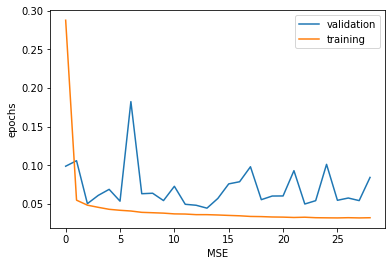

In [28]:
if load_dataset_from_excel:
  [modelo,history] = make_prediction(dataFrame,best_results_of_simulation00[len(best_results_of_simulation00)-1]['parameters'])
else:
  [modelo,history] = make_prediction(dataFrame,best_results_of_simulation00[len(best_results_of_simulation00)-1][1]['parameters'])

plt.plot(history.history['val_mse'][0:len(history.history['val_mse'])-1], label = "validation")
plt.plot(history.history['mse'][0:len(history.history['val_mse'])-1], label = "training")
plt.xlabel('MSE')
plt.ylabel('epochs')
plt.legend()
plt.show()

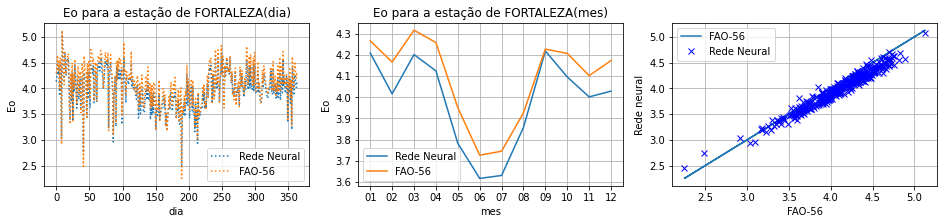

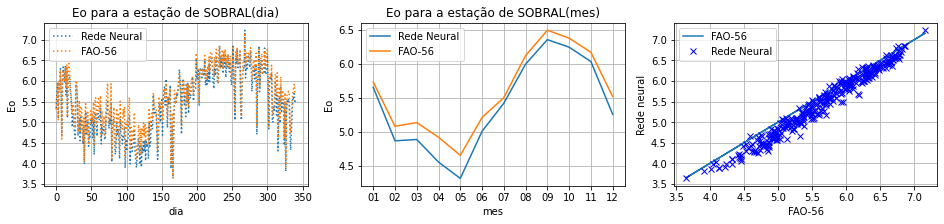

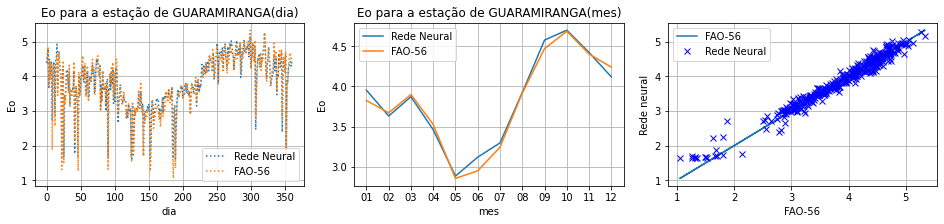

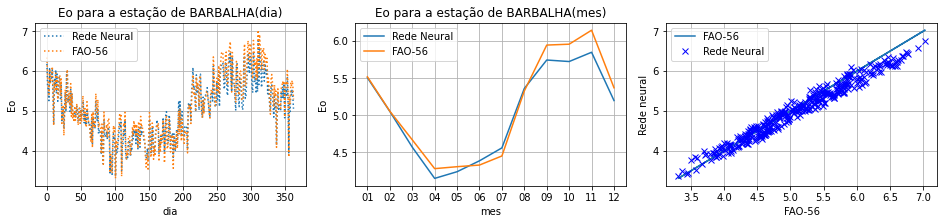

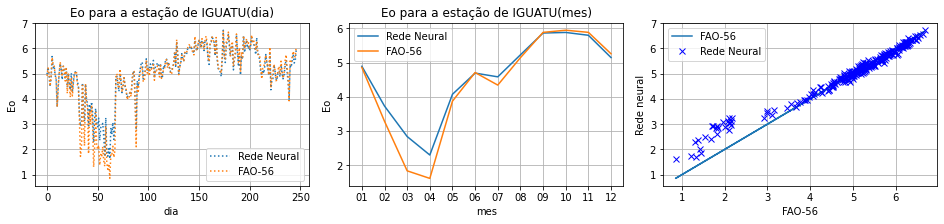

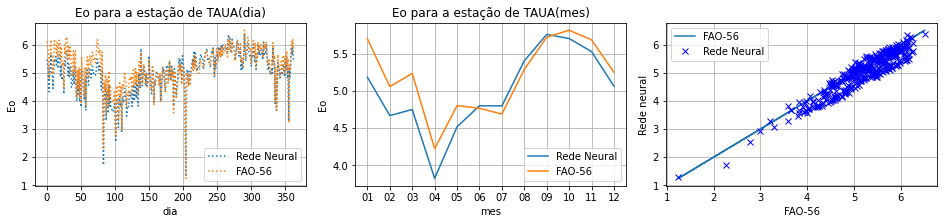

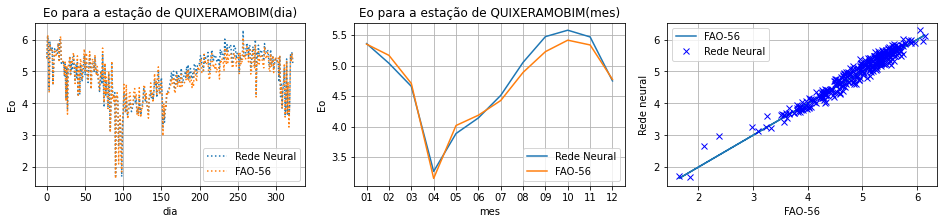

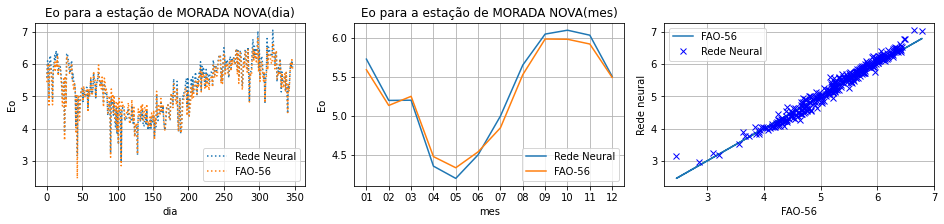

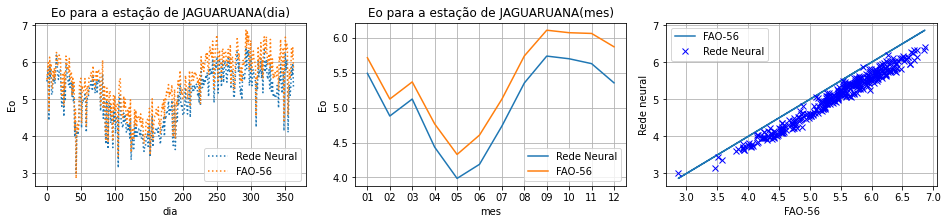

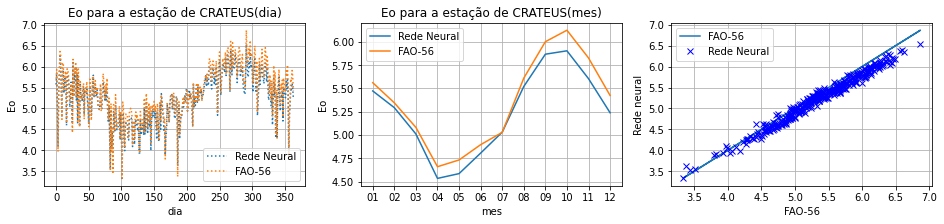

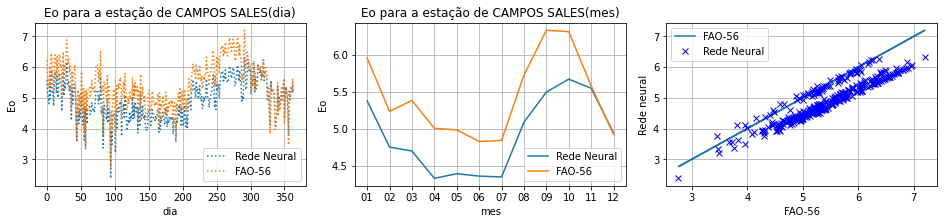

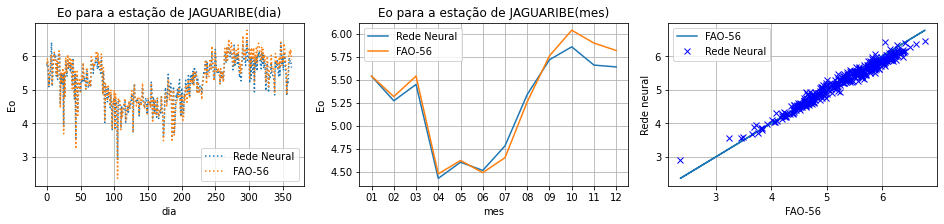

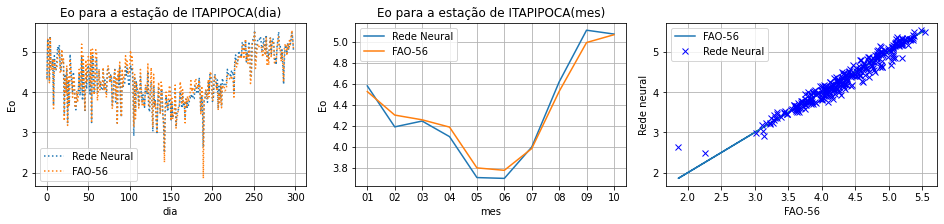

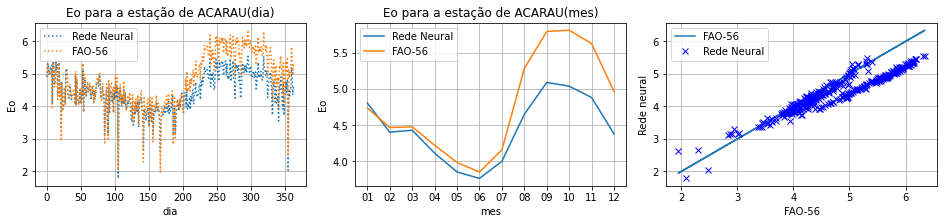

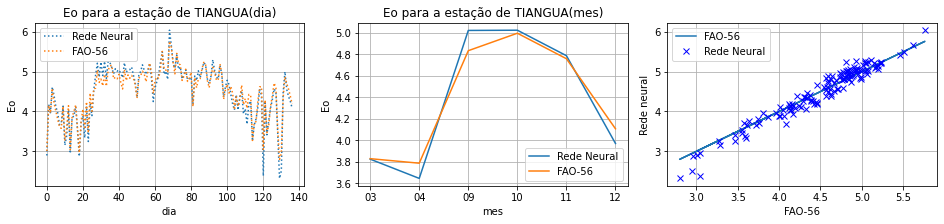

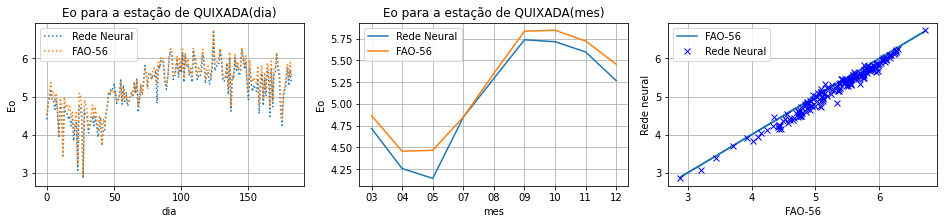

In [29]:
test_labels = pd.DataFrame(modelo.test_labels)
prediction_test = pd.DataFrame(modelo.prediction_test)

test_labels['data'] = modelo.test_labels.index
prediction_test['data'] = modelo.test_labels.index

test_labels['mes'] = [mes for mes in modelo.mes]
prediction_test['mes'] = [mes for mes in modelo.mes]
test_labels['ano'] = [mes for mes in modelo.ano]
prediction_test['ano'] = [mes for mes in modelo.ano]

test_labels_gruopby_data = test_labels.groupby(['data']).mean()
prediction_test_gruopby_data = prediction_test.groupby(['data']).mean()

test_labels_gruopby_month = test_labels.groupby(['mes']).mean()
prediction_test_gruopby_month = prediction_test.groupby(['mes']).mean()

test_labels['estacao_id'] = [id for id in modelo.estacao_id ]
prediction_test['estacao_id'] = [id for id in modelo.estacao_id ]

results_by_estation = get_graphs_and_metrics_grouped_by_estacao_id(prediction_test,test_labels,'mes','2018',localization,id_2,show_picture = True)

In [30]:
display(results_by_estation.T)

,código da estação,Quantidade de dados,coeficiente de determinação(dia),MSE(dia),coeficiente de determinação(mes),MSE(mes)
FORTALEZA,A305,364,0.87912,0.019057,0.685693,0.01318
SOBRAL,A306,341,0.893226,0.0527,0.891331,0.045843
GUARAMIRANGA,A314,361,0.964285,0.022754,0.977223,0.006925
BARBALHA,A315,364,0.94802,0.032099,0.938896,0.021796
IGUATU,A319,247,0.939612,0.100428,0.879089,0.149733
TAUA,A324,363,0.796556,0.09891,0.708798,0.083166
QUIXERAMOBIM,A325,323,0.943543,0.027757,0.966301,0.015931
MORADA NOVA,A332,348,0.96077,0.020674,0.973957,0.010666
JAGUARUANA,A339,364,0.737032,0.144924,0.599238,0.134098
CRATEUS,A342,364,0.938014,0.024629,0.90504,0.01836


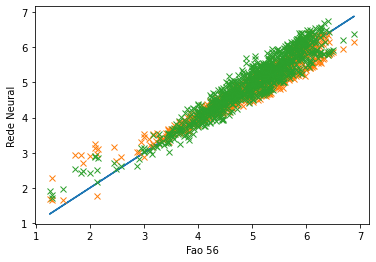

0.9404720090741887


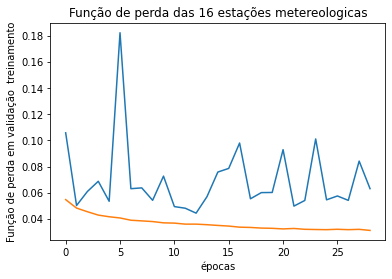

In [31]:
modelo.compare(1000,True)
plt.plot(history.history['val_loss'][1:],label = 'Validação')
plt.plot(history.history['loss'][1:], label = 'Treinamento')
plt.title('Função de perda das 16 estações metereologicas')
plt.xlabel('épocas')
plt.ylabel('Função de perda em validação  treinamento')
plt.show()

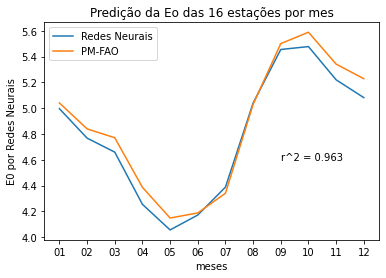

0.9630515355994035

In [32]:
plt.plot(prediction_test_gruopby_month, label = 'Redes Neurais')
plt.plot(test_labels_gruopby_month, label = 'PM-FAO')
plt.legend()
plt.text(8,4.6,'r^2 = '+str(round(r2_score(prediction_test_gruopby_month,test_labels_gruopby_month),3)))
plt.xlabel('meses')
plt.ylabel('E0 por Redes Neurais')
plt.title('Predição da Eo das 16 estações por mes')
plt.show()

display(r2_score(prediction_test_gruopby_month,test_labels_gruopby_month))

## **All results of the simulation 01**

This subsection is included the graphs and metrics such as  $r^2$ and MSE per monthly mean and day. The graphs that present the monthly mean results are related to 2018, the year which contains most data from the test data set.

0.939158763751363


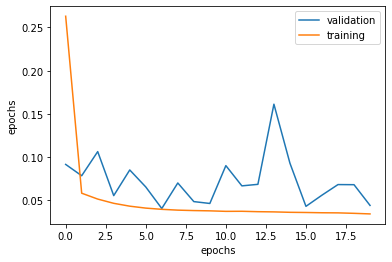

In [33]:
if load_dataset_from_excel:
  [modelo,history] = make_prediction(dataFrame,best_results_of_simulation01[len(best_results_of_simulation01)-1]['parameters'])
else:
  [modelo,history] = make_prediction(dataFrame,best_results_of_simulation01[len(best_results_of_simulation01)-1][1]['parameters'])

plt.plot(history.history['val_mse'][:40], label = "validation")
plt.plot(history.history['mse'][:40], label = "training")
plt.xlabel('epochs')
plt.ylabel('epochs')
plt.legend()
plt.show()

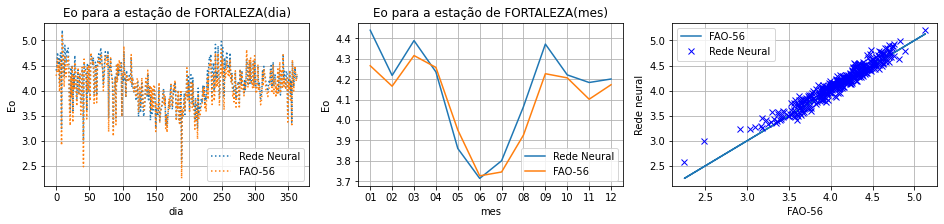

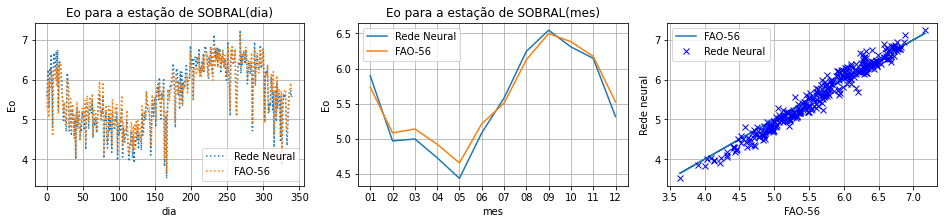

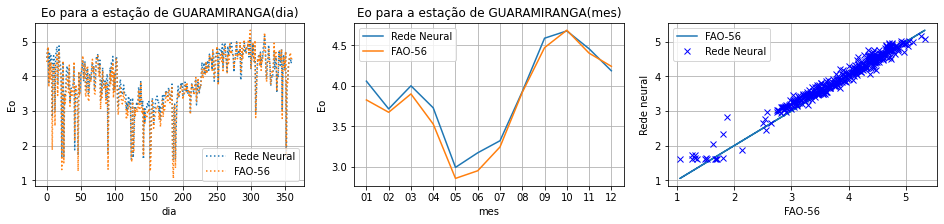

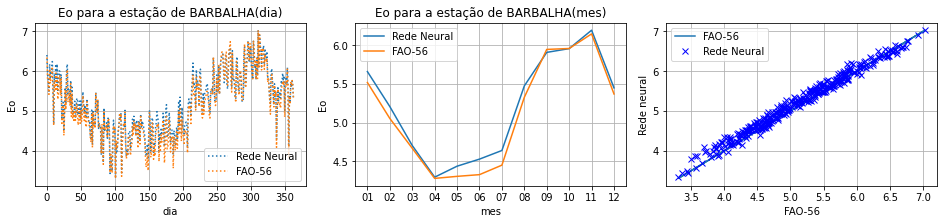

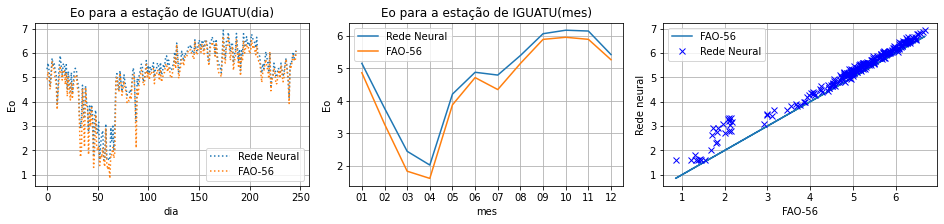

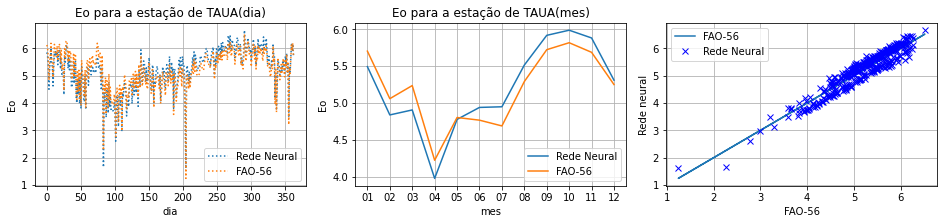

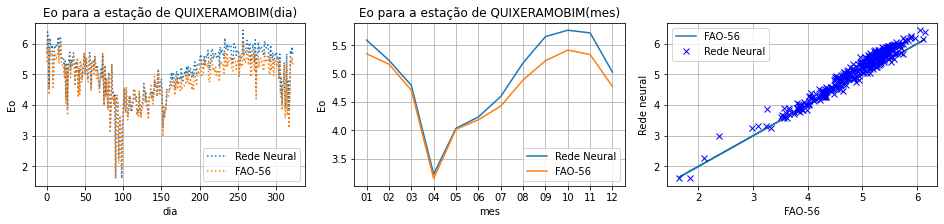

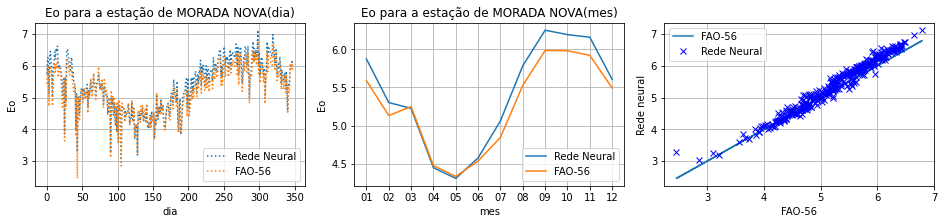

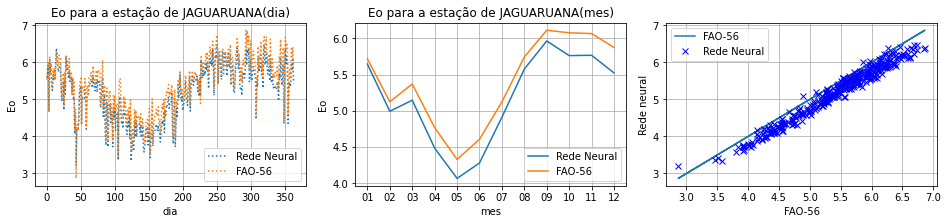

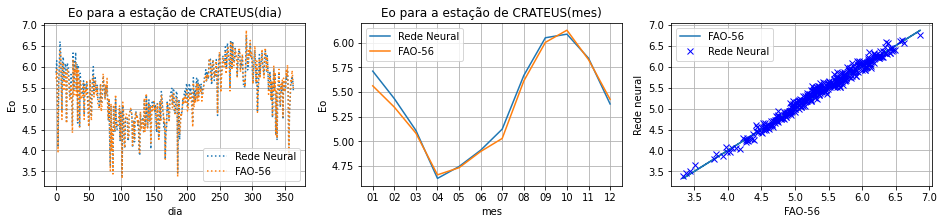

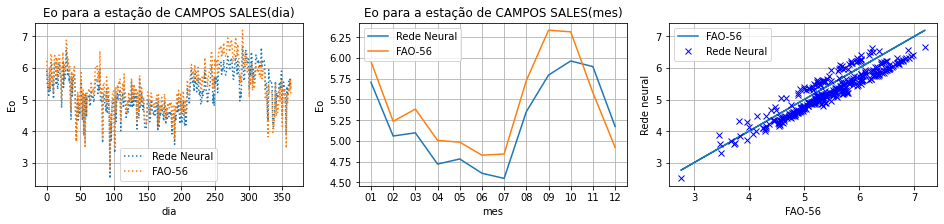

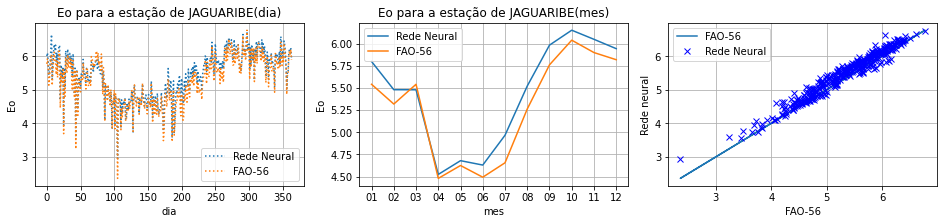

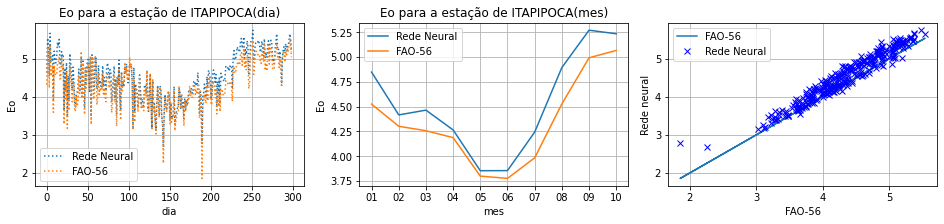

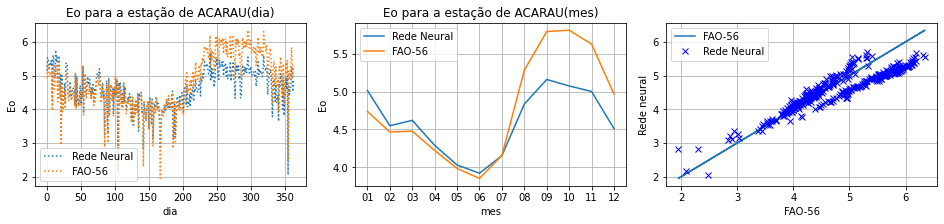

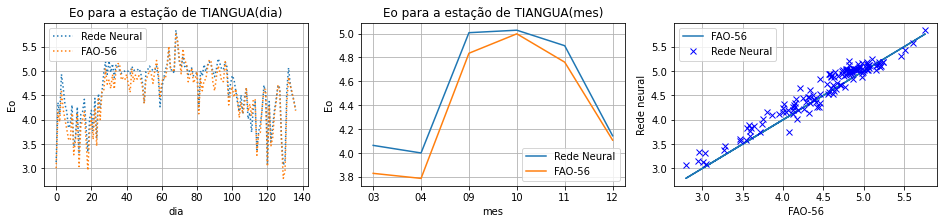

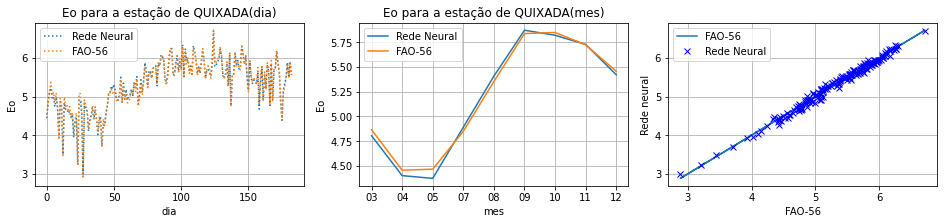

In [34]:
test_labels = pd.DataFrame(modelo.test_labels)
prediction_test = pd.DataFrame(modelo.prediction_test)

test_labels['data'] = modelo.test_labels.index
prediction_test['data'] = modelo.test_labels.index

test_labels['mes'] = [mes for mes in modelo.mes]
prediction_test['mes'] = [mes for mes in modelo.mes]
test_labels['ano'] = [mes for mes in modelo.ano]
prediction_test['ano'] = [mes for mes in modelo.ano]

test_labels_gruopby_data = test_labels.groupby(['data']).mean()
prediction_test_gruopby_data = prediction_test.groupby(['data']).mean()

test_labels_gruopby_month = test_labels.groupby(['mes']).mean()
prediction_test_gruopby_month = prediction_test.groupby(['mes']).mean()

test_labels['estacao_id'] = [id for id in modelo.estacao_id ]
prediction_test['estacao_id'] = [id for id in modelo.estacao_id ]

#display(prediction_test)

results_by_estation = get_graphs_and_metrics_grouped_by_estacao_id(prediction_test,test_labels,'mes','2018',localization,id_2,show_picture = True)

In [35]:
display(results_by_estation.T)

,código da estação,Quantidade de dados,coeficiente de determinação(dia),MSE(dia),coeficiente de determinação(mes),MSE(mes)
FORTALEZA,A305,364,0.912995,0.013716,0.839574,0.008208
SOBRAL,A306,341,0.939106,0.030055,0.956236,0.01947
GUARAMIRANGA,A314,361,0.95225,0.030422,0.938838,0.016688
BARBALHA,A315,364,0.96816,0.019662,0.964719,0.014169
IGUATU,A319,247,0.928668,0.118628,0.931147,0.118043
TAUA,A324,363,0.888393,0.054261,0.864115,0.043215
QUIXERAMOBIM,A325,323,0.845145,0.076134,0.894646,0.059602
MORADA NOVA,A332,348,0.915431,0.044567,0.922059,0.033978
JAGUARUANA,A339,364,0.86977,0.071771,0.833924,0.061277
CRATEUS,A342,364,0.978249,0.008642,0.981331,0.004189


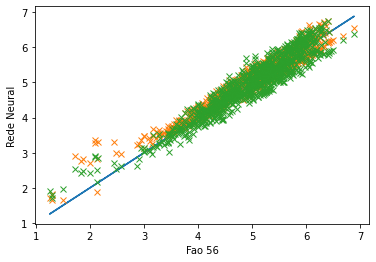

0.939158763751363


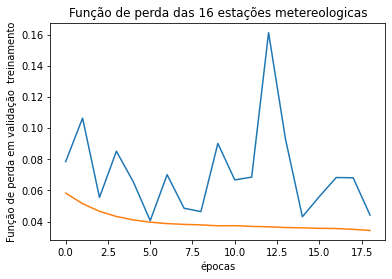

In [36]:
modelo.compare(1000,True)
plt.title('Função de perda das 16 estações metereologicas')
plt.xlabel('épocas')
plt.ylabel('Função de perda em validação  treinamento')
plt.plot(history.history['val_loss'][1:40], label = 'validação')
plt.plot(history.history['loss'][1:40], label = 'treinamento')
plt.show()

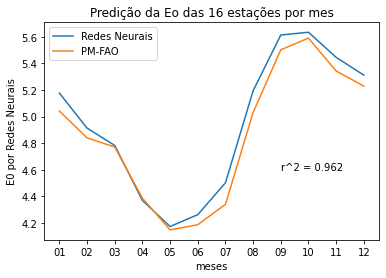

0.9622074202765698

In [37]:
plt.plot(prediction_test_gruopby_month, label = 'Redes Neurais')
plt.plot(test_labels_gruopby_month, label = 'PM-FAO')
plt.legend()
plt.text(8,4.6,'r^2 = '+str(round(r2_score(prediction_test_gruopby_month,test_labels_gruopby_month),3)))
plt.xlabel('meses')
plt.ylabel('E0 por Redes Neurais')
plt.title('Predição da Eo das 16 estações por mes')
plt.show()

display(r2_score(prediction_test_gruopby_month,test_labels_gruopby_month))

## **Seaching for outliers**

In [45]:
modelo0_sample = result_table00.sample(40)
modelo1_sample = result_table01.sample(40)

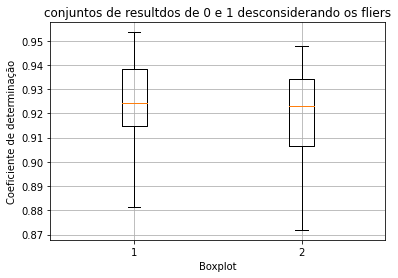

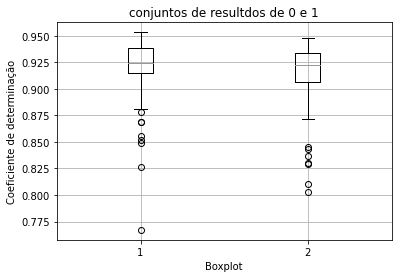

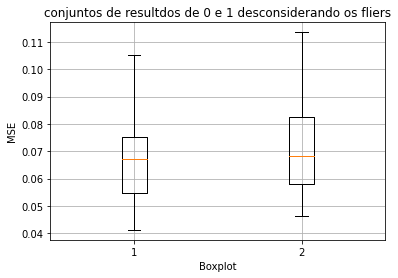

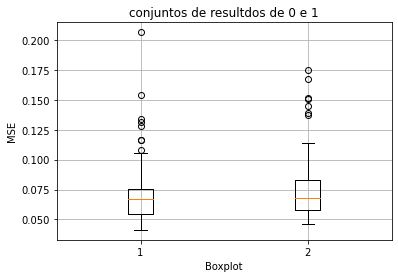

In [38]:
creating_two_boxplot(result_table00['coeficiente de determinação'],result_table01['coeficiente de determinação'],'Coeficiente de determinação','conjuntos de resultdos de 0 e 1 desconsiderando os fliers',False)

creating_two_boxplot(result_table00['coeficiente de determinação'],result_table01['coeficiente de determinação'],'Coeficiente de determinação','conjuntos de resultdos de 0 e 1',True)

creating_two_boxplot(result_table00['MSE'],result_table01['MSE'],'MSE','conjuntos de resultdos de 0 e 1 desconsiderando os fliers',False)

creating_two_boxplot(result_table00['MSE'],result_table01['MSE'],'MSE','conjuntos de resultdos de 0 e 1',True)



#The hypothesis test#

Based on the set of the hyperparameters that produced the highest $r^2$ in simulation 1 and simulation 2, 2 same-size data sets are created using them. In order to ensure that one set of the hyperparameters is better than the other one in terms of mean, the hypothesis test is carried out following the below statements.

$h_{0} :$ Both means are statistically similar.

$h_{1} :$ The means of the distributions underlying the samples are unequal

If the p-value is less or equals 0.05, the null hypothesis($h_{0}$) is rejected and the alternative hypothesis($h_{1}$) is accepted. Otherwise, if the p-value is larger than 0.05, the $h_0$ is accepted. In relation to this project, accepting the $h_0$ means that both sets of hyperparameters produce the same results statistically speaking. Thus, it is more advantageous to work with the first one as it uses fewer features.  

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

## Mean and standard deviation of both samples

To verify how far the two result sets are from each other in terms of the mean and standard deviation of metrics $r^2$ and MSE.

In [60]:
print(f"r^2 da simulação 0: Media={modelo0_sample['coeficiente de determinação'].mean()} e DP = {modelo0_sample['coeficiente de determinação'].std()}")
print(f"r^2 da simulação 1: Media={modelo1_sample['coeficiente de determinação'].mean()} e DP = {modelo1_sample['coeficiente de determinação'].std()}")
print(f"MSE da simulação 0: Media={modelo0_sample['MSE'].mean()} e DP = {modelo0_sample['MSE'].std()}")
print(f"MSE da simulação 1: Media={modelo1_sample['MSE'].mean()} e DP = {modelo1_sample['MSE'].std()}")

r^2 da simulação 0: Media=0.91336586089338 e DP = 0.032340187847541065
r^2 da simulação 1: Media=0.9126742026247008 e DP = 0.032186224483283364
MSE da simulação 0: Media=0.07680981148727004 e DP = 0.028672804481561617
MSE da simulação 1: Media=0.07742303557858884 e DP = 0.028536300591680216


##Performing the F-test##
To carry out the t-test, it's necessary to ensure whether the variances of both populations are the same or not. Then, F-test is performed.


In [67]:
f_test_p_value = f_test(modelo0_sample['coeficiente de determinação'],modelo1_sample['coeficiente de determinação'])[1] 
if f_test_p_value <= 0.05:
  print('As 2 populações não apresetam a mesmas variança')
else:
  print('As 2 populações apresetam a mesmas variança')

print(f"O valor do p valor é {f_test_p_value}")

As 2 populações apresetam a mesmas variança
O valor do p valor é 0.4881884975091243


##Performing the T-test

The T-test is going to tell us whether the result sets have different means. That test will be applied twice in each result set based on the metrics $r^2$ and MSE.

### MSE

In [69]:
t_test_p_value_r2 = ttest_ind(modelo0_sample['coeficiente de determinação'],modelo1_sample['coeficiente de determinação'],alternative='two-sided',equal_var=True)[1]

if t_test_p_value_r2 <= 0.05:
  print("ambas populações não apresentam a mesma média")
else:
  print("ambas populações apresentam a mesma média")

print(t_test_p_value_r2)

ambas populações apresentam a mesma média
0.9238670713027592


###$r^2$

In [70]:
t_test_p_value_MSE = ttest_ind(modelo0_sample['MSE'],modelo1_sample['MSE'],alternative='two-sided',equal_var=True)[1]

if t_test_p_value_MSE <= 0.05:
  print("ambas populações não apresentam a mesma média")
else:
  print("ambas populações apresentam a mesma média")

print(t_test_p_value_MSE)

ambas populações apresentam a mesma média
0.92386707130276


#checking the correlation between the features and target variable.

To measure the correlation, the Pearson correlation coefficient is obtained for each available feature in the model in relation to the target variable, providing the direction and strength of that relationship. This metric varies from -1 to 1, for larger values than 0, the correlation is positive. for smaller values than 0, the correlation is negative then it gives opposite directions which means the increase in the feature causes the decrease in the target. the closer that metric is to the 1 and -1 values, the stronger is that correlation.

In [ ]:
correlation_of_features = r_regression(dataFrame.drop(columns={'latitude','longitude','altura','estacao_id','dia do ano','data completa','Eo_FAO','mes','ano'}),dataFrame['Eo_FAO'])
features_name = dataFrame.drop(columns={'latitude','longitude','altura','estacao_id','dia do ano','data completa','Eo_FAO','mes','ano'}).keys()
correlations_table = dict()

for index in range(len(features_name)):
  correlations_table[index] = features_name[index]
  
pd.DataFrame(correlation_of_features).T.rename(columns=correlations_table)

,TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C),UMIDADE REL. MAX. NA HORA ANT. (AUT)(%),TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C),UMIDADE REL. MIN. NA HORA ANT. (AUT)(%),RADIACAO GLOBAL(Kj/m²),"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)","UMIDADE RELATIVA DO AR, HORARIA(%)","VENTO, VELOCIDADE HORARIA(m/s)",temperatura media,Eo_samani
0,0.81284,-0.291154,0.030777,-0.715946,0.079393,0.148632,-0.575127,-0.085032,0.576381,0.967537
